# Translating multiomics single-cell data

In this tutorial, we showcase the use of the {class}`~moscot.problems.cross_modality.TranslationProblem`, as outlined in {cite}`demetci-scot:22`, to integrate different modalities of single-cell data. In particular, we compute a mapping to translate **chromatin accessibility** (ATAC) and **gene expression** (RNA).

## The method
The {class}`~moscot.problems.cross_modality.TranslationProblem` uses Fused Gromov-Wasserstein (FGW) {cite}`vayer:2020`, a type of Optimal Transport (OT), for computing cell-to-cell correspondence probabilities between multiomics single-cell data. As input data, we consider a [Latent Semantic Indexing (LSI)](https://muon.readthedocs.io/en/latest/api/generated/muon.atac.tl.lsi.html) embedding for the ATAC data and a [Principal Component Analysis (PCA)](https://scanpy.readthedocs.io/en/stable/generated/scanpy.pp.pca.html) embedding of the RNA. Since these distinct feature spaces are not directly comparable, we employ a quadratic **Gromov-Wasserstein** (GW) {cite}`nitzan:19,peyre:2016` term that compares pairwise ATAC and RNA cells and seeks to preserve some local geometry between similar cells. Additionally, we may include a linear **Wasserstein** (W) term that contains a [scVI integration](https://scvi-tools.org) of the gene expression raw counts of the RNA and the gene activity raw counts of the ATAC data. Leaving out the linear term makes this a pure GW problem.

Additionally, we use entropic regularization {cite}`cuturi:2013` to speed up computations and to improve the statistical properties of the solution {cite}`peyre:19`. In the objective function, we compare $N$ source (here ATAC) to $M$ target (here RNA) cells. We use the following definitions: 

- $\varepsilon$: weight given to entropic regularitation. Larger values will lead to more "blurred" couplings. 
- $\alpha$: weight given to GW (distinct features) vs. W (joint features) terms.

## Preliminaries

In [16]:
import warnings

import moscot.plotting as mtp
from moscot import datasets
from moscot.problems.cross_modality import TranslationProblem

import numpy as np
import pandas as pd
import scipy
from sklearn import preprocessing as pp

import matplotlib.pyplot as plt

import anndata as ad
import scanpy as sc

warnings.simplefilter("ignore", UserWarning)
warnings.simplefilter("ignore", FutureWarning)

### Define utility functions
We will use the average FOSCTTM (fraction of samples closer to the true match) measure implemented below for evaluation (metric used in {cite}`demetci-scot:22`). This metric measures the alignment between two domains by computing the average fraction of samples that are closer to their true match than a fixed sample, where a perfect alignment results in a FOSCTTM value of zero.

In [3]:
def foscttm(
    x: np.ndarray,
    y: np.ndarray,
) -> float:
    d = scipy.spatial.distance_matrix(x, y)
    foscttm_x = (d < np.expand_dims(np.diag(d), axis=1)).mean(axis=1)
    foscttm_y = (d < np.expand_dims(np.diag(d), axis=0)).mean(axis=0)
    fracs = []
    for i in range(len(foscttm_x)):
        fracs.append((foscttm_x[i] + foscttm_y[i]) / 2)
    return np.mean(fracs).round(4)

### Dataset description
This dataset contains preprocessed bone marrow mononuclear cell data from the [Open Problems - Multimodal Single-Cell Integration* NeurIPS competition 2021](https://openproblems.bio/competitions/neurips_2021_docs/data/dataset.html).

Within the {func}`~moscot.datasets.bone_marrow` dataset, we store two  {class}`~anndata.AnnData` objects for the Site 1, Donor 1 ATAC and RNA data. The dataset includes the LSI and PCA embedding of ATAC and RNA respectively, as well as the scVI integration of gene expression and gene activity.

### Data loading
We download the {func}`~moscot.datasets.bone_marrow` data (approx. 43MiB).

In [4]:
adata_atac = datasets.bone_marrow(rna=False)
adata_rna = datasets.bone_marrow(rna=True)
adata_atac, adata_rna

(AnnData object with n_obs × n_vars = 6224 × 8000
     obs: 'ATAC_nCount_peaks', 'ATAC_nucleosome_signal', 'cell_type', 'batch'
     uns: 'cell_type_colors', 'neighbors'
     obsm: 'ATAC_lsi_full', 'ATAC_lsi_red', 'X_umap', 'geneactivity_scvi'
     layers: 'counts'
     obsp: 'connectivities', 'distances',
 AnnData object with n_obs × n_vars = 6224 × 2000
     obs: 'GEX_n_counts', 'GEX_n_genes', 'cell_type', 'batch'
     uns: 'cell_type_colors', 'neighbors'
     obsm: 'GEX_X_pca', 'X_umap', 'geneactivity_scvi'
     layers: 'counts'
     obsp: 'connectivities', 'distances')

### Preprocessing
We perform a L2-normalization of the ATAC data using [`sklearn.preprocessing.normalize`](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.normalize.html) to scale the samples to have unit norm. This is useful, since we quantify the similarity of pair of samples.

In [5]:
adata_atac.obsm["ATAC_lsi_l2_norm"] = pp.normalize(
    adata_atac.obsm["ATAC_lsi_full"], norm="l2"
)

### Visualization
Let’s take a look at the ATAC and RNA data by plotting a UMAP of the respective domain before the alignment, colored according to cell type.

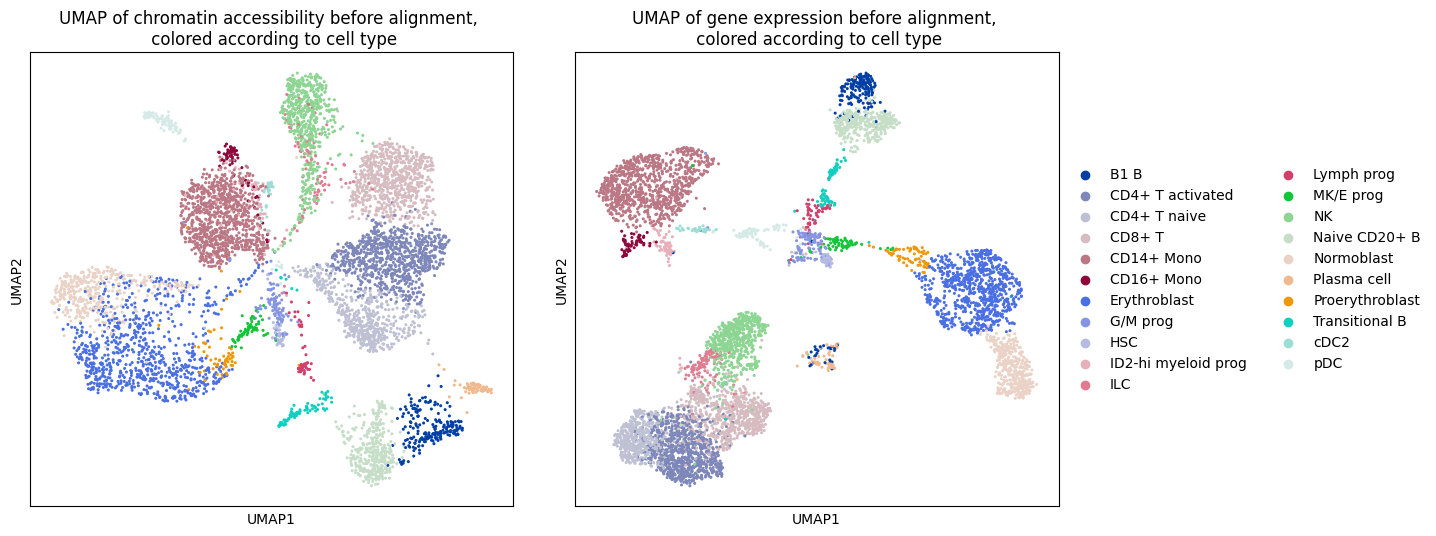

In [6]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))
sc.pl.umap(adata_atac, color="cell_type", ax=ax1, show=False)
ax1.legend().remove()
ax1.set_title(
    "UMAP of chromatin accessibility before alignment, \n colored according to cell type"
)
sc.pl.umap(adata_rna, color="cell_type", ax=ax2, show=False)
ax2.set_title(
    "UMAP of gene expression before alignment, \n colored according to cell type"
)
plt.tight_layout(pad=3.0)
plt.show()

## Prepare the {class}`~moscot.problems.cross_modality.TranslationProblem`

We need to initialize the {class}`~moscot.problems.cross_modality.TranslationProblem` by passing the source and target {class}`~anndata.AnnData` objects. After initialization, we need to {meth}`~moscot.problems.cross_modality.TranslationProblem.prepare` the problem. In this particular case, we need to pay attention to 3 parameters:

- `src_attr`: specifies the attribute in {class}`~anndata.AnnData` that contains the source distribution. In our case it refers to the key in {attr}`~anndata.AnnData.obsm`
that stores the ATAC LSI embedding.
- `tgt_attr`: specifies the attribute in {class}`~anndata.AnnData` that contains the target distribution. In our case it refers to the key in {attr}`~anndata.AnnData.obsm`
that stores the RNA PCA embedding.
- `joint_attr`[optional]: specifies a joint attribute over a common feature space to incorporate a linear term into the quadratic optimization problem. Initially, we consider the pure Gromov-Wasserstein setting and subsequently explore the fused problem.

In [7]:
tp = TranslationProblem(adata_src=adata_atac, adata_tgt=adata_rna)
tp = tp.prepare(src_attr="ATAC_lsi_l2_norm", tgt_attr="GEX_X_pca")

## Solve the {class}`~moscot.problems.cross_modality.TranslationProblem`
In fused quadratic problems, the `alpha` parameter defines the convex combination between the quadratic and linear terms. By default, `alpha = 1`, that is, we only consider the quadratic problem, ignoring the `joint_attr`. We choose a small value for `epsilon` to obtain a sparse transport map.

In [8]:
tp = tp.solve(alpha=1.0, epsilon=1e-3)

INFO     Solving `1` problems                                                                                      
INFO     Solving problem OTProblem[stage='prepared', shape=(6224, 6224)].                                          


## Translate the {class}`~moscot.problems.cross_modality.TranslationProblem`
We can now project one domain onto the other. The boolean parameter `forward` determines the direction of the barycentric projection. In our case, we project the source distribution {class}`~anndata.AnnData` (`ATAC`) onto the target distribution {class}`~anndata.AnnData` (`RNA`), therefore we use `forward = True`. The function {meth}`~moscot.problems.cross_modality.TranslationProblem.translate` returns the translated object in the target space (or source space respectively).

In [9]:
translated = tp.translate(source="src", target="tgt", forward=True)

## Analyzing the translation
We will use the average FOSCTTM metric implemented above to analyze the alignment performance.

In [10]:
print(
    "Average FOSCTTM score of translating ATAC onto RNA: ",
    foscttm(adata_rna.obsm["GEX_X_pca"], translated),
)

Average FOSCTTM score of translating ATAC onto RNA:  0.3676


For the sake of visualization, we concatenate the translated chromatin accessibility points mapped to the gene expression PCA domain to the original gene expression PCA data. Then we plot a UMAP of the concatenated data in the gene expression domain, colored according to the original domain and cell type.

In [11]:
adata = sc.concat(
    [adata_atac, adata_rna],
    join="outer",
    label="batch",
    keys=["ATAC (translated)", "RNA"],
)
adata.obsm["X_translated_1"] = np.concatenate(
    (translated, adata_rna.obsm["GEX_X_pca"]), axis=0
)
sc.pp.neighbors(adata, use_rep="X_translated_1")
sc.tl.umap(adata)

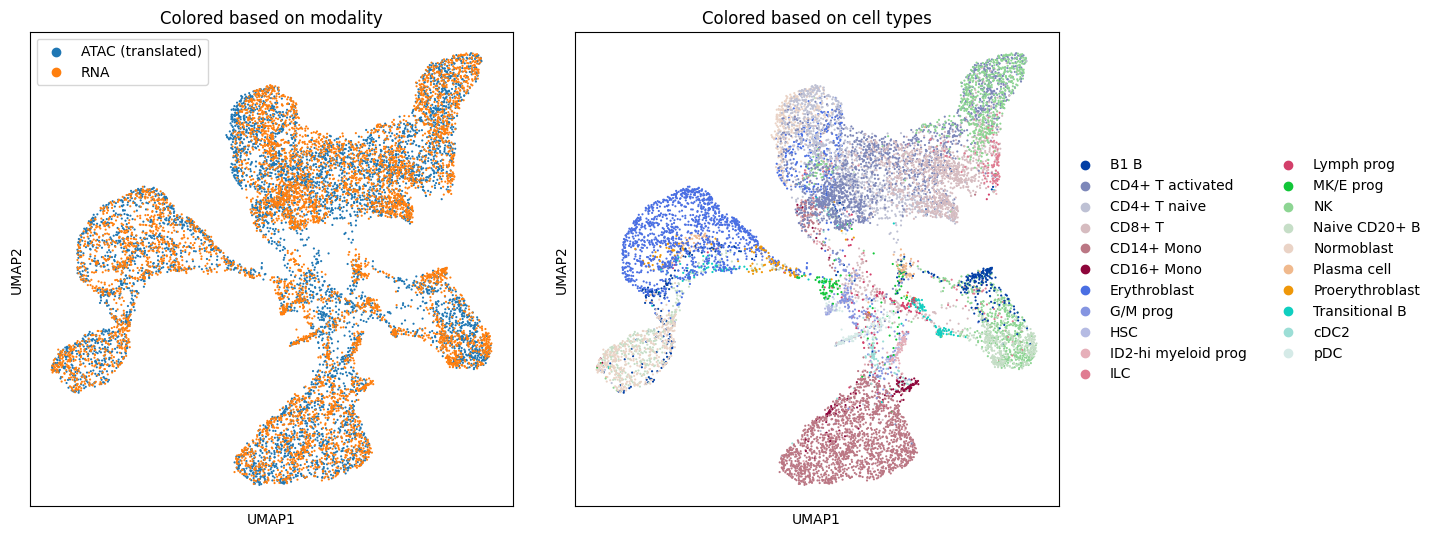

In [12]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))
sc.pl.umap(adata, color=["batch"], ax=ax1, show=False)
ax1.legend()
ax1.set_title("Colored based on modality")
sc.pl.umap(adata, color=["cell_type"], ax=ax2, show=False)
ax2.set_title("Colored based on cell types")
plt.tight_layout(pad=3.0)
plt.show()

## Extend the {class}`~moscot.problems.cross_modality.TranslationProblem` to the fused setting
We proceed to extend the {class}`~moscot.problems.cross_modality.TranslationProblem` to incorporate the fused setting. In this regard, we aim to evaluate the potential benefits of augmenting the quadratic problem with a linear term. Therefore, we {meth}`~moscot.problems.space.MappingProblem.prepare` a new problem, by employing a scVI integration of the gene activity data in the `joint_attr`. Then, we {meth}`~moscot.problems.cross_modality.TranslationProblem.solve` the resulting problem, with `alpha=0.9` and the epsilon parameter identical to that used in the pure Gromov-Wasserstein case.

In [13]:
ftp = TranslationProblem(adata_src=adata_atac, adata_tgt=adata_rna)
ftp = ftp.prepare(
    src_attr="ATAC_lsi_l2_norm", tgt_attr="GEX_X_pca", joint_attr="geneactivity_scvi"
)
ftp = ftp.solve(epsilon=1e-3, alpha=0.9)
translated_fused = ftp.translate(source="src", target="tgt", forward=True)
print(
    "Average FOSCTTM score for translating ATAC onto RNA: ",
    foscttm(adata_rna.obsm["GEX_X_pca"], translated_fused),
)

INFO     Solving `1` problems                                                                                      
INFO     Solving problem OTProblem[stage='prepared', shape=(6224, 6224)].                                          
Average FOSCTTM score for translating ATAC onto RNA:  0.1015


The experimental results demonstrate a significant improvement in the fused setting when compared to the pure Gromov-Wasserstein case.

### Visualize translation

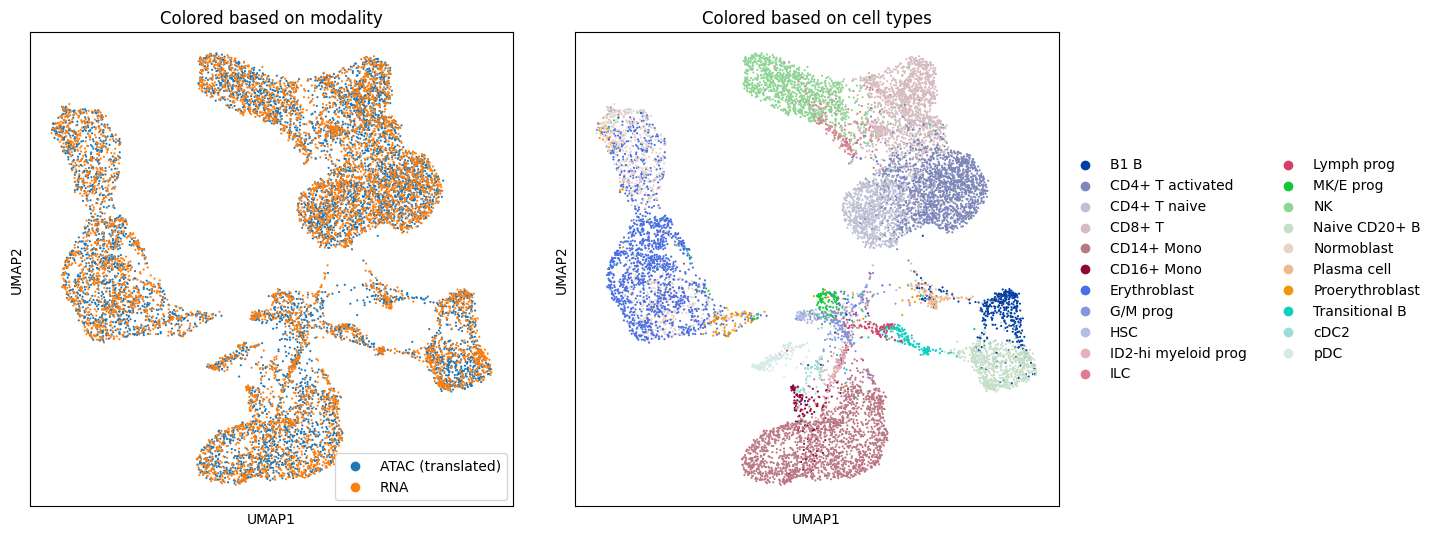

In [14]:
adata.obsm["X_translated_2"] = np.concatenate(
    (translated_fused, adata_rna.obsm["GEX_X_pca"]), axis=0
)
sc.pp.neighbors(adata, use_rep="X_translated_2")
sc.tl.umap(adata)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))
sc.pl.umap(adata, color=["batch"], ax=ax1, show=False)
ax1.legend()
ax1.set_title("Colored based on modality")
sc.pl.umap(adata, color=["cell_type"], ax=ax2, show=False)
ax2.set_title("Colored based on cell types")
plt.tight_layout(pad=3.0)
plt.show()

## Analyzing cell type transitions
The cell type transition matrix provides a mapping of cell types from one modality to another and can be used to examine the correspondence between cell types across different datasets. The resulting matrix illustrates which cell types are mapped where thereby enabling further downstream analyses. We order the annotations explicitly by providing a dictionary for `source_groups` and `target_groups`.

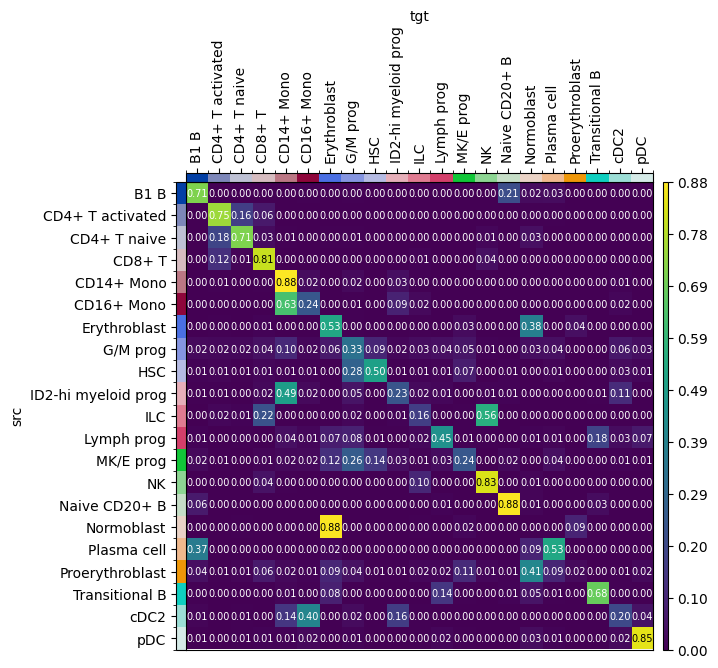

In [18]:
order = adata_atac.obs["cell_type"].cat.categories

cell_transition = ftp.cell_transition(
    source="src",
    target="tgt",
    source_groups={"cell_type": order},
    target_groups={"cell_type": order},
    forward=True,
    key_added="ftp_transitions",
)

mtp.cell_transition(ftp, figsize=(5, 5), uns_key="ftp_transitions")

The rows sum up to 1, as for each cell type in a certain row, the columns indicate where the cells are translated to. The {class}`~moscot.problems.cross_modality.TranslationProblem` fails to distinguish between Erythroblast and Normoblast cells as only 53/100 Erythroblast cells are mapped correctly while 38/100 Erythroblast are mapped to Normoblast cells. In contrast, 88% of CD14+ Mono cells are correctly mapped to CD14+ Mono cells.